# Exercise 2$^+$  Filtering 

**Aim:** The purpose of this lab is to get you started thinking about frequency content of time series

**Learning outcomes:** At the end of this lab, you will be able to:
1. Filter data using windows
2. Check that the window used has "good" spectral properties (a good frequency response)
<!--4. Use the functions including: nanmean, detrend, polyfit, polyval, disp, grid, find, isnan, sqrt, and the operators ==, ~ and .^2.-->

**Data:** You will work with a tide gauge time series.

**Directions:** Answer the questions, create an `*.ipynb` and one figure.

```{seealso}
Jonathan Lilly's course on time series analysis for more about spectra: [https://www.jmlilly.net/course/index.html](https://www.jmlilly.net/course/index.html).  
```
<hr>

## Create a notebook & load the data

1. Create an `*.ipynb` containing the commands for this assignment, or copy this file.  
    
    ```{admonition} File naming convention
    Name your python notebook something useful `ex<X>-<slug>-<Lastname>-seaocn.ipynb` where you replace `<X>` with the exercise number and `<slug>` with the short slug to name the topic, and `<Lastname>` with your last name.
    
    Figures should be named something like `ex<X>fig<Y>-<slug>-<Lastname>-seaocn.png` where you replace `<X>` with the exercise number, `<Y>` with the figure number, and `<Lastname>` with your last name.
    ```

2. Import necessary packages.  

    For example, `matplotlib` and `pandas` and `numpy` and `xarray`.  You may also need
    ```{python}
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import xarray as xr
    from datetime import datetime
    ```

    If you are missing any of these packages, please refer to [Resources: Python](../resource/python).

In [1]:
# Importing required packages here
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import datetime

# We are going to need some extra packages here
import scipy.signal as sg  #Package for signal analysis
#from scipy import fft as spfft
from scipy.fft import fft, fftshift 
import scipy.ndimage as si #Another package for signal analysis
from multitaper import MTSpec  #using German Prieto's multitaper package, https://github.com/gaprieto/multitaper

plt.rcParams["figure.figsize"] = (10,6.5) #set default figure size
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'

### Download some data + quick check what's there

In the time series exercise, you did some quick and easy filtering by making annual averages.  Now we'll try something a little more complicated using tide gauge data.

1. Pick a tide gauge from the east coast of the USA: [https://www.bodc.ac.uk/data/hosted_data_systems/sea_level/international/north_atlantic/#Duck](https://www.bodc.ac.uk/data/hosted_data_systems/sea_level/international/north_atlantic/#Duck) and download the data in `*.nc` format.

2. Put the file in your `data/` directory.

3. Load the data using `xarray` into something called `td`.

4. Squeeze the data in `xarray` to remove extra dimensions of your data variable.

5. Print the data to see what is in there.

6. Make a simple plot of your data variable `sea_level_1` against time.



In [2]:
# Where are your data
file_path = '../data/'
filename = 'w9006.nc'
fname = file_path + filename

# Load the data
td = xr.open_dataset(fname)
td = td.squeeze()
print(td)

# Quick plot data
plt.plot(td.time,td.sea_level_1)



FileNotFoundError: [Errno 2] No such file or directory: '/Users/eddifying/Library/Mobile Documents/com~apple~CloudDocs/Work/teaching/SeaOcn-UHH/coursebook_seaocn/seaocn-cb/data/w9006.nc'

## Filter the data

### Select a one year time period to work with

1. Pick a year that looks filled in.  I.e., straight lines between big blocks of color are probably because there's not data.

2. Take a look at the attributes to try to verify that your year has no gaps

   ```{python}
   td.attrs
   ```

    ```{seealso}
    [https://docs.xarray.dev/en/stable/user-guide/indexing.html](https://docs.xarray.dev/en/stable/user-guide/indexing.html)
    ```

3. Subselect the data using the `.loc` command.  For example, if you would like to extract the month of January in 1995, you would do:

   ```{python}
   td_jan95 = td.loc[dict(time=slice("1995-01-01", "1995-01-31T23:59:59"))]
   ```


    ```


In [111]:
td_jan95 = td.loc[dict(time=slice("1995-01-01", "1995-01-31T23:59:59"))]
#td_1995 = td_1995.drop_vars(["woce_date","woce_time","sea_level_quality_flag_1"])

#print(td_jan95)
td_1995 = td.loc[dict(time=slice("1995-01-01", "1995-12-31T23:59:59"))]


### Fig. 1 Calculate a running averages 

You will use `xarray.DataArray.rolling()`

1. From your one year period, plot a two week period.

    ```{python}
    td_1995 = td.loc[dict(time=slice("1995-01-01", "1995-12-31T23:59:59"))]
    plt.plot(td_1995.time,td_1995.sea_level_1)
    xlim = [datetime.date(1995,1,1), datetime.date(1995,1,14)]
    ax.set_xlim(xlim)
    fig.autofmt_xdate()    

3. Calculate a rolling average (moving average) over 5 hours from your dataset, and add this to your plot in red.

    ```{python}
    sla5 = td_1995.sea_level_1.rolling(time=5, center=False).mean()
    ```

4. Recalculate this using the option `center=True`, and add this to your plot in green.
   
5. Plot your figure and name it fig1 using the file naming convention.

What is the difference between using `center=False` or `True`?  

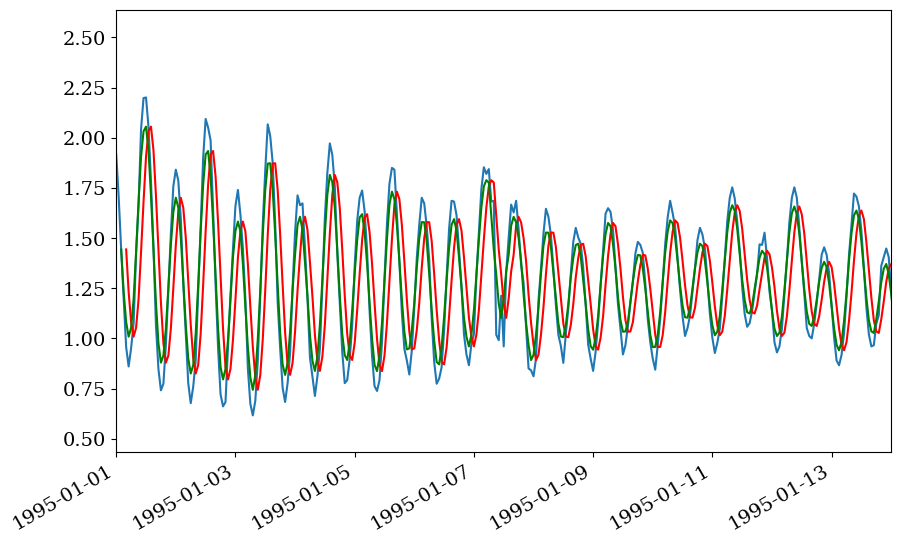

In [112]:
# Plot one month
fig, ax = plt.subplots()
ax.plot(td_1995.time,td_1995.sea_level_1)
xlim = [datetime.date(1995,1,1), datetime.date(1995,1,14)]
ax.set_xlim(xlim)
fig.autofmt_xdate()

# Add appropriate x- and y-axis labels (with units)

# Calculate a moving average
sla5noctr = td_1995.sea_level_1.rolling(time=5, center=False).mean()
sla5 = td_1995.sea_level_1.rolling(time=5, center=True).mean()
ax.plot(td_1995.time,sla5noctr,color='red')
ax.plot(td_1995.time,sla5,color='green')

### Experiment with windows 

Let's try removing the tides.  Most tides that we normally think about are diurnal or semi-diurnal, so let's smooth the data with a 1-day filter.

1. Using the same dataset, now smooth with 24 hours.  Adjust y-axis limits to the nearest 0.1 m.  Did we get out all the wobbles?

<!--no-->

2. Create a window.  When we are using a default rolling average, it is a rectangular or "boxcar" window (where "boxcar" refers to a train car that looks like a container on a container ship).   Note that when importing packages above, we imported `scipy.signal` as `sg`.
   
    ```{python}
    myboxcar = sg.boxcar(100)
    mytukey = sg.tukey(100)
    myparzen = sg.parzen(100)
    ```

    *Personal favourite: Tukey*.  When you use it on a dataset, it looks a lot like a boxcar, but less jaggedy, and the spectral properties (frequency response) are good.  You can take a quick look at the "frequency response" for different windows by clicking the function in the `scipy` documentation.  If the side lobes drop away quickly and smoothly (to low decibels) from the center peak, this is better.  
    
```{seealso}
Window types in `scipy`: [https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows)
```

/var/folders/t1/z5bp59k95119nw35yqv699t40000gn/T/ipykernel_11744/2598423311.py:18: RuntimeWarning: divide by zero encountered in log10
  response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))


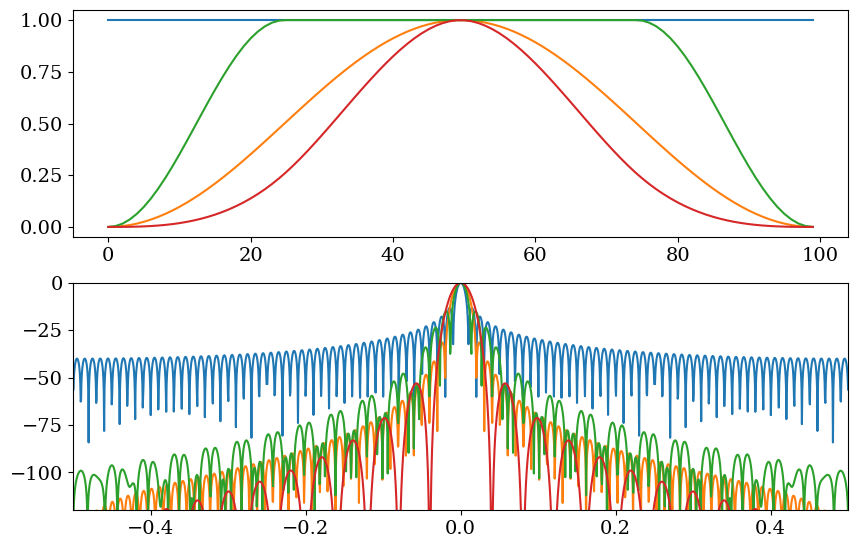

In [113]:
# Create a few window types.
myboxcar = sg.boxcar(100)
myhanning = sg.hann(100)
mytukey = sg.tukey(100)
myparzen = sg.parzen(100)

fig, axs = plt.subplots(2)
axs[0].plot(myboxcar)
axs[0].plot(myhanning)
axs[0].plot(mytukeywin)
axs[0].plot(myparzen)

wins = [myboxcar, myhanning, mytukey, myparzen]

for window in wins:
    A = fft(window, 2048) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
    axs[1].plot(freq, response)
    axs[1].axis([-0.5, 0.5, -120, 0])


## Fig. 2 Calculate moving averages with different filters

1. Recalculate your moving averages using two types of filters.  One of these should be a boxcar, and the other is your choice.

2. Plot the two filtered time series and the original data on a new set of axes, and zoom in to a 2-week period for better visibility.
   
3. Export this figure as fig2.

                               sea_level_1
time                                      
1995-01-01 00:00:00.000000000        1.917
1995-01-01 01:00:00.000107520        1.704
1995-01-01 02:00:00.000214528        1.442
1995-01-01 03:00:00.000000000        1.198
1995-01-01 04:00:00.000429056        0.957
...                                    ...
1995-12-31 19:00:00.001716736        1.582
1995-12-31 19:59:59.998283264        1.667
1995-12-31 21:00:00.000000000        1.693
1995-12-31 22:00:00.001716736        1.546
1995-12-31 22:59:59.998283264        1.388

[8760 rows x 1 columns]


(9131.0, 9144.0)

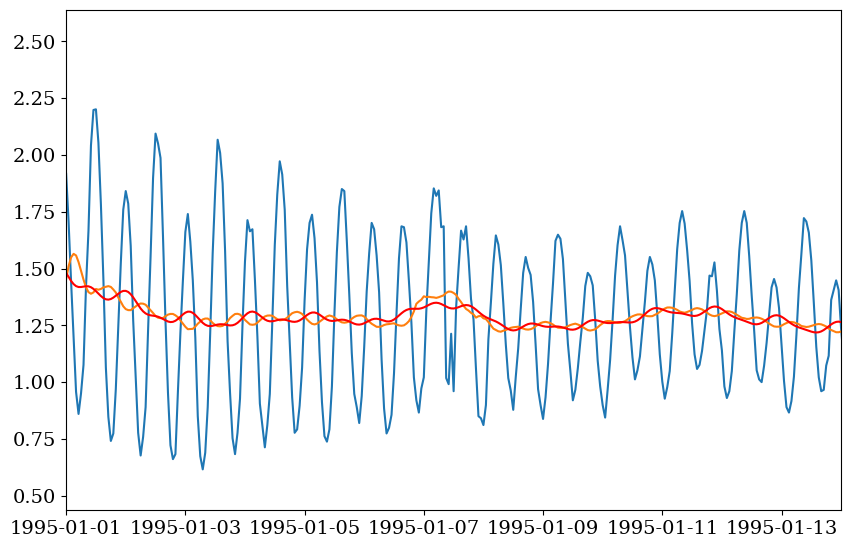

In [152]:
# Calculate a 1-day moving mean-average using a tukey filter.
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html
#td_1995 = td_1995.drop_vars(["latitude", "longitude"])
sla_df = td_1995.sea_level_1.to_dataframe()
type(sla_df)
print(sla_df)
# Pandas, unlike xarray, doesn't have the time linked to the data as the dimension.  
# Here you need to specify the window length in the number of data points.  Since our data are hourly, a 24-hour window
# is 24.
sla_df24tukey = sla_df.rolling(48, center=True, win_type='tukey', min_periods=1).mean()
sla_df24box = sla_df.rolling(24, center=True, win_type='boxcar', min_periods=1).mean()
fig, ax = plt.subplots()
ax.plot(td_1995.time,td_1995.sea_level_1)
ax.plot(td_1995.time,sla_df24box)
ax.plot(td_1995.time,sla_df24tukey,color = 'red')
ax.set_xlim(xlim)
#ax.set_ylim([1.2, 1.5])

# Look back at your window.  Why is the result with the Tukey window still bumpier than the result with the boxcar?
# What length Tukey window would you need to use in order to have the flat center part of the Tukey at least 24-hours?

## Fitting a harmonic (optional)

More typically, to remove tides, the tidal constituents can be removed using a harmonic fit, followed by e.g. a 40-hour filter.  For a boxcar, this would be a 40-hour boxcar.  For a tukey, it would be something longer.

**Explore:** See whether you can fit a harmonic to your tidal time series.  What are the major tidal constituents?  

- Some packages exist to help with this: e.g., https://github.com/moflaher/ttide_py

**Explore:** Go a little deeper into time series analysis by considering spectra. Spectra can immediately help you identify dominant frequencies in  your time series, whether they are seasonal (a 365-day cycle) or tidal (12- or 12.4-hr).  An example notebook can be found here: https://www.jmlilly.net/course/labs/html/SpectralAnalysis-Python.html from Jonathan Lilly's time series analysis [course](https://www.jmlilly.net/course/index.html).

In [ ]:
# Your code here (optional)


## Fig. 3 Regridding data

Now suppose you need to compare your tidal time series with a daily temperature record (for example).  You want to calculate a linear regression, but the lengths of the time grids are different.  You have some options.

1. Average your data into 1 day averages.  Try this using the methods from the previous exercise.

2. Subsample your data into the value nearest to noon each day.

3. Linearly interpolate your data onto the time dimension of the temperature record.

Try these methods and consider what the differences might mean.

4. For the purpose of this exercise, simply create these new time series and plot a week or a month's worth of data with all three time series on the same plot.



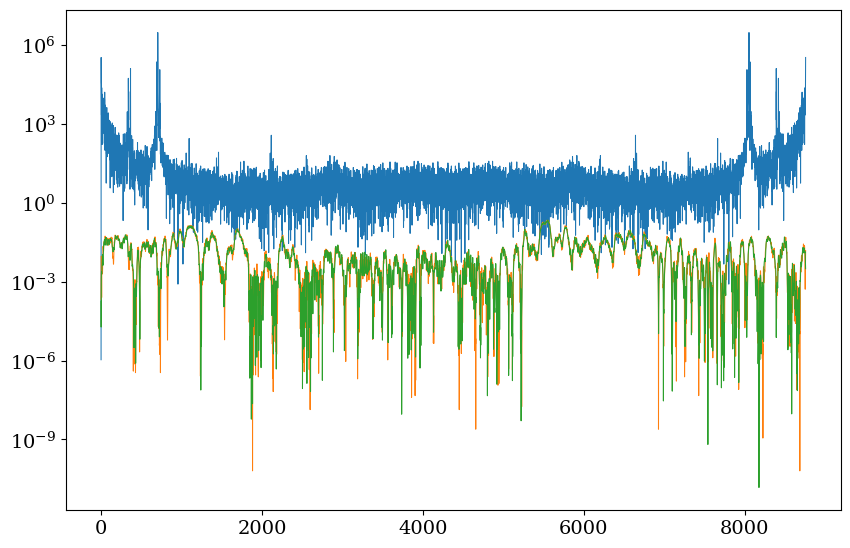

In [150]:
# Has this removed the diurnal cycle?
cv = td_1995.sea_level_1.values
cv2 = sla_df24box
cv3 = sla_df24tukey
fig, ax = plt.subplots(1, 1)
ax.semilogy(np.abs(fft(cv-cv.mean()))**2,linewidth=0.75)
ax.semilogy(np.abs(fft(cv2-cv2.mean()))**2,linewidth=0.75)
ax.semilogy(np.abs(fft(cv3-cv3.mean()))**2,linewidth=0.75)


Text(0, 0.5, 'Power Spectral Density (cm$^2$/s$^2$ days)')

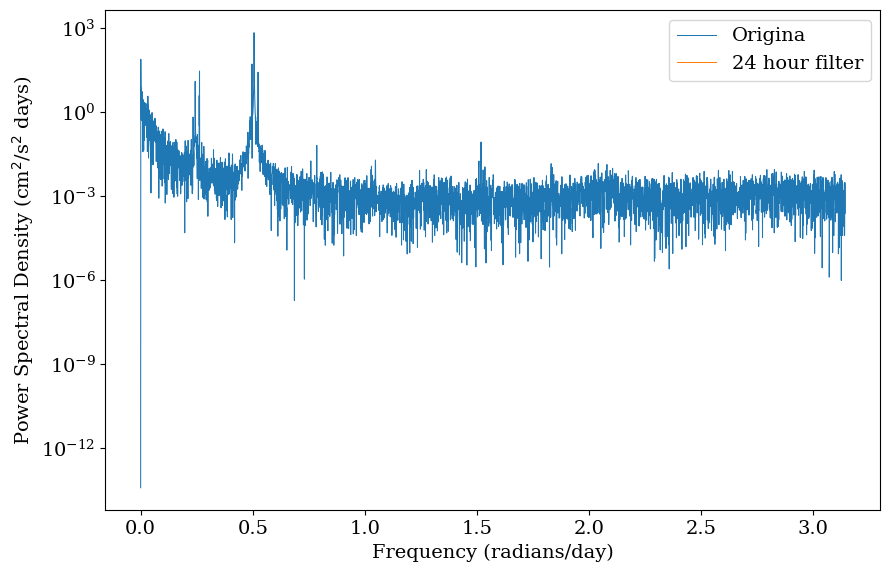

In [149]:
dt = 1/24
f, S = sg.periodogram(cv-cv.mean(), fs=1/dt) #fs = sampling frequency (cyclic)
f2, S2 = sg.periodogram(cv2-cv2.mean(), fs=1/dt) #fs = sampling frequency (cyclic)
omega = f*2*np.pi #convert cyclic frequency to radian frequency
omega2 = f2*2*np.pi

fig, ax = plt.subplots(1, 1)
ax.semilogy( omega[np.where(omega>=0)],S[np.where(omega>=0)],linewidth=0.75)#plot positive side
ax.semilogy( omega2[np.where(omega2>=0)],S2[np.where(omega2>=0)],linewidth=0.75)#plot positive side
#ax.semilogy(-omega[np.where(omega<=0)],S[np.where(omega<=0)],linewidth=0.75)#plot negative side
#ax.autoscale(enable=True, tight=True)
#ax.set_ylim(1e-2, 1e3)
#fig.tight_layout()

ax.legend(['Origina','24 hour filter'])
plt.xlabel('Frequency (radians/day)')
plt.ylabel('Power Spectral Density (cm$^2$/s$^2$ days)')
#plt.title('Periodogram Rotary Spectral Estimate');


In [148]:
cv2.mean()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])